# Question 1

In [258]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil, floor 
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from sklearn.preprocessing import PolynomialFeatures



np.random.seed(99)
rng = np.random.default_rng()

In [253]:
def generate_samples(dataset_size, priors, num_dim, means, cov, thresholds):
        # Determine dimensionality from mixture PDF parameters
        # Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
  u = np.random.rand(dataset_size)

  labels = u >= priors[0]
  X = np.zeros((dataset_size, num_dim))
  for i in range(4):
    indice = np.argwhere((thresholds[i-1] <= u) & (u <= thresholds[i]))[:, 0]
    X[indice, :] = multivariate_normal.rvs(means[i-1], cov, len(indice))
  return labels, X

def get_posteriors(dataset_size, priors, num_classes, means, cov, x):
    posteriors = np.zeros(shape=[dataset_size, num_classes])
    for class_label in range(num_classes):
        if class_label == 0:
            posteriors[:, class_label] = 0.5 * (multivariate_normal.pdf(x, means[0], cov) + 
                                            multivariate_normal.pdf(x, means[1], cov)) * priors[class_label]
        else:
            posteriors[:, class_label] = 0.5 * (multivariate_normal.pdf(x, means[2], cov) + 
                                            multivariate_normal.pdf(x, means[3], cov)) * priors[class_label]

    return posteriors

Data Generation

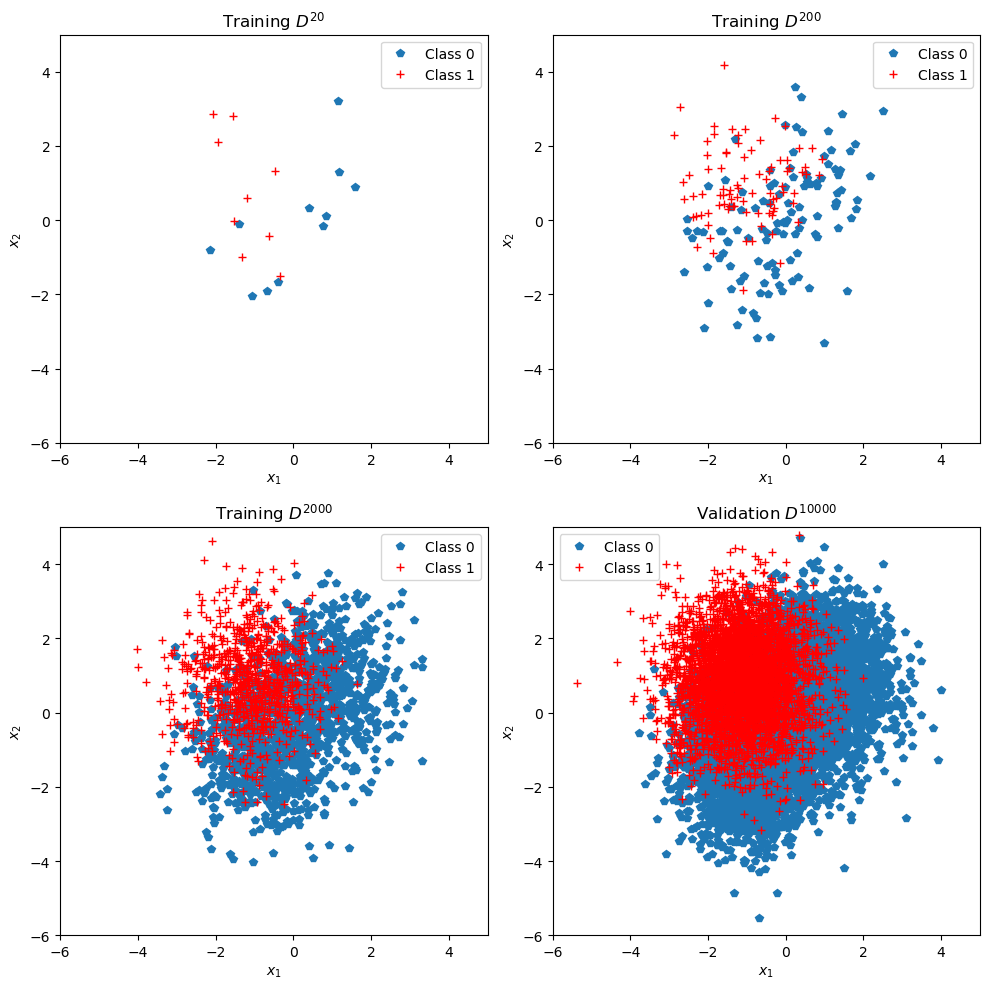

In [254]:
# constants
datasets_train_size = [20,200,2000]
dataset_val_size = 10000
num_dim = 2
num_classes = 2
priors = np.array([0.6, 0.4])
# it uses the thresholds to jointly decide both the class and which Gaussian component within that 
# class to use for generating the sample; if first we choose one and then the other, it is conditional
thresholds = np.array([0, 0.3, 0.6, 1.0])

# parameters of class-conditional Gaussians pdfs
mean0 = np.array([-0.9,-1.1])
mean1 = np.array([0.8,0.75])
mean2 = np.array([-1.1,0.9])
mean3 = np.array([0.9,-0.75])
means = np.array([mean0, mean1, mean2, mean3])
cov = np.array([[0.75, 0], [0, 1.25]])

# Plot the original data and their true labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# generate samples for training datasets
X_train = []
labels_train = []
dist_labels_train = []
t = 0 #axis index
for dataset_train_size in datasets_train_size:
    class_labels, x = generate_samples(dataset_train_size, priors, num_dim, means, cov, thresholds)
    X_train.append(x)
    labels_train.append(class_labels)
    dist_labels_train.append(np.array((sum(class_labels == 0), sum(class_labels == 1))))
    # Axis fancy indexing for the sake of plotting correctly in subplots
    ax[floor(t/2), t%2].set_title(r"Training $D^{%d}$" % (dataset_train_size))
    ax[floor(t/2), t%2].plot(x[class_labels==0, 0], x[class_labels==0, 1], 'p', label="Class 0")
    ax[floor(t/2), t%2].plot(x[class_labels==1, 0], x[class_labels==1, 1], 'r+', label="Class 1")
    ax[floor(t/2), t%2].set_xlabel(r"$x_1$")
    ax[floor(t/2), t%2].set_ylabel(r"$x_2$")
    ax[floor(t/2), t%2].legend()

    t += 1

# generate samples for validation dataset
labels_val, X_val = generate_samples(dataset_val_size, priors, num_dim, means, cov, thresholds)
dist_labels_val = np.array((sum(labels_val == 0), sum(labels_val == 1)))

ax[1, 1].set_title(r"Validation $D^{%d}$" % (dataset_val_size))
ax[1, 1].plot(X_val[labels_val==0, 0], X_val[labels_val==0, 1], 'p', label="Class 0")
ax[1, 1].plot(X_val[labels_val==1, 0], X_val[labels_val==1, 1], 'r+', label="Class 1")
ax[1, 1].set_xlabel(r"$x_1$")
ax[1, 1].set_ylabel(r"$x_2$")
ax[1, 1].legend()

# Using validation set samples to limit axes (most samples drawn, highest odds of spanning sample space)
x1_valid_lim = (floor(np.min(X_val[:,0])), ceil(np.max(X_val[:,0])))
x2_valid_lim = (floor(np.min(X_val[:,1])), ceil(np.max(X_val[:,1])))
# Keep axis-equal so there is new skewed perspective due to a greater range along one axis
plt.setp(ax, xlim=x1_valid_lim, ylim=x2_valid_lim)
plt.tight_layout()
plt.show()

# posterior pdf
posteriors_train = []
for x in X_train:
    posteriors_train.append(get_posteriors(x.shape[0], priors, num_classes, means, cov, x))

posterior_val = get_posteriors(len(X_val), priors, num_classes, means, cov, X_val)




### Part 1

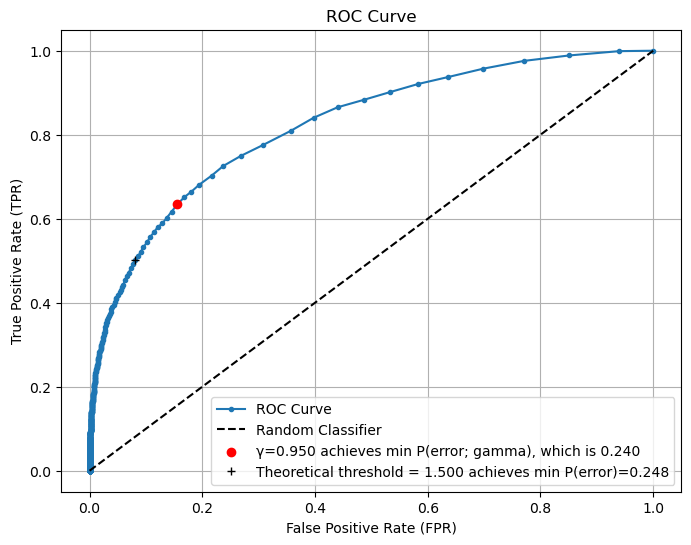

In [255]:
gamma_values = np.linspace(start=0, stop=1000, num=20000)
gamma_values = np.append(gamma_values, np.inf)

# For every gamma, we compute the TPR, FPR and probabilities of error
TPRs = []
FPRs = []
prob_errors = []

for gamma in gamma_values:
    ratio = posterior_val[:,1]/posterior_val[:,0]
    decisions = ratio > gamma # np array of 1,0 decisions
    
    TP = np.sum((decisions == 1) & (labels_val == 1))
    FP = np.sum((decisions == 1) & (labels_val == 0))
    FN = np.sum((decisions == 0) & (labels_val == 1))
    TN = np.sum((decisions == 0) & (labels_val == 0))

    TPR = TP/(TP+FN) # true positive detection probability
    FPR = FP/(FP+TN) # false positive probability
    FNR = FN/(FN+TP)
    prob_error = FPR * priors[0] + FNR * priors[1]

    TPRs.append(TPR)
    FPRs.append(FPR)
    prob_errors.append(prob_error)

min_prob_error = min(prob_errors)
optimal_gamma_index = prob_errors.index(min_prob_error)
optimal_gamma = gamma_values[optimal_gamma_index]

# theoretical optimal gamma
decisions_theo = (posterior_val[:,1]/posterior_val[:,0]) > priors[0]/priors[1] # np array of 1,0 decisions

TP_theo = np.sum((decisions_theo == 1) & (labels_val == 1))
FP_theo = np.sum((decisions_theo == 1) & (labels_val == 0))
FN_theo = np.sum((decisions_theo == 0) & (labels_val == 1))
TN_theo = np.sum((decisions_theo == 0) & (labels_val == 0))

TPR_theo = TP_theo/(TP_theo+FN_theo) # true positive detection probability
FPR_theo = FP_theo/(FP_theo+TN_theo) # false positive probability
FNR_theo = FN_theo/(FN_theo+TP_theo)
prob_error_theo = FPR_theo * priors[0] + FNR_theo * priors[1]

# Plotting the ROC Curve and highlighting the optimal gamma
plt.figure(figsize=(8, 6))
plt.plot(FPRs, TPRs, label='ROC Curve', marker = '.', zorder=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Dashed diagonal line (random classifier)
plt.scatter(FPRs[optimal_gamma_index], TPRs[optimal_gamma_index], color='red', zorder=3, label=f'γ={optimal_gamma:.3f} achieves min P(error; gamma), which is {min_prob_error:.3f}')
plt.plot(FPR_theo, TPR_theo, '+', label=f'Theoretical threshold = {priors[0]/priors[1]:.3f} achieves min P(error)={prob_error_theo:.3f}', color = 'black', zorder=4)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Part 2

In [256]:
# Sigmoid function for logistic regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Negative Log-Likelihood Loss function for logistic regression
def nll_loss(w, X, y):
    z = np.dot(X, w)
    predictions = sigmoid(z)
    return log_loss(y, predictions)

# Training logistic regression model using MLE
def train_logistic_regression(X, y):
    w0 = np.zeros(X.shape[1])  # Initialize weights as zeros
    result = minimize(nll_loss, w0, args=(X, y), method='BFGS')  # Optimize the NLL
    return result.x  # Return the optimized weights

# Logistic regression classifier
def classify(X, w):
    probabilities = sigmoid(np.dot(X, w))
    return (probabilities >= 0.5).astype(int)

def plot_decision_boundary_with_distinct_markers(X, y, w, ax, labels):
    """
    Plots the decision boundary defined by the logistic regression model (w), 
    along with the correctly and incorrectly classified points from the validation set,
    using different markers for the two true classes.
    """
    # Meshgrid for plotting decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    
    # Define x1 range (horizontal axis)
    x1_vals = np.linspace(x_min, x_max, 100)  # Choose an appropriate range for x1

    # Calculate corresponding x2 values based on the equation: x2 = -(w1 / w2) * x1
    x2_vals = -(w[0] / w[1]) * x1_vals

    # Plot the line
    ax.plot(x1_vals, x2_vals, color='blue', label=f'Line with w: {w}') 

    # Correctly and incorrectly classified points
    TN = (y == 0) & (y == labels)
    TP = (y == 1) & (y == labels)
    FN = (y == 0) & (y != labels)
    FP = (y == 1) & (y != labels)


    FPR = np.sum(FP)/(np.sum(FP)+np.sum(TN)) # false positive probability
    FNR = np.sum(FN)/(np.sum(FN)+np.sum(TP))
    prob_error = FPR * priors[0] + FNR * priors[1]
    
    # True class 0 marker: 'o', True class 1 marker: 's'
    # Correctly classified points
    ax.scatter(X[TN, 0], X[TN, 1], marker='o', color='green', label='Correct Class 0', edgecolor='k')
    ax.scatter(X[TP, 0], X[TP, 1], marker='s', color='green', label='Correct Class 1', edgecolor='k')
    
    # Incorrectly classified points
    ax.scatter(X[FN, 0], X[FN, 1], marker='o', color='red', label='Incorrect Class 0', edgecolor='k')
    ax.scatter(X[FP, 0], X[FP, 1], marker='s', color='red', label='Incorrect Class 1', edgecolor='k')
    
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.legend(loc='upper right')
    ax.set_title("Decision Boundary and Classified Points")

    return prob_error

Probability of error on training dataset using the model trained with the training dataset D_20: 0.2626
Probability of error on validation dataset using the model trained with the training dataset D_20: 0.3214
Probability of error on training dataset using the model trained with the training dataset D_200: 0.3324
Probability of error on validation dataset using the model trained with the training dataset D_200: 0.3145
Probability of error on training dataset using the model trained with the training dataset D_2000: 0.3096
Probability of error on validation dataset using the model trained with the training dataset D_2000: 0.3143


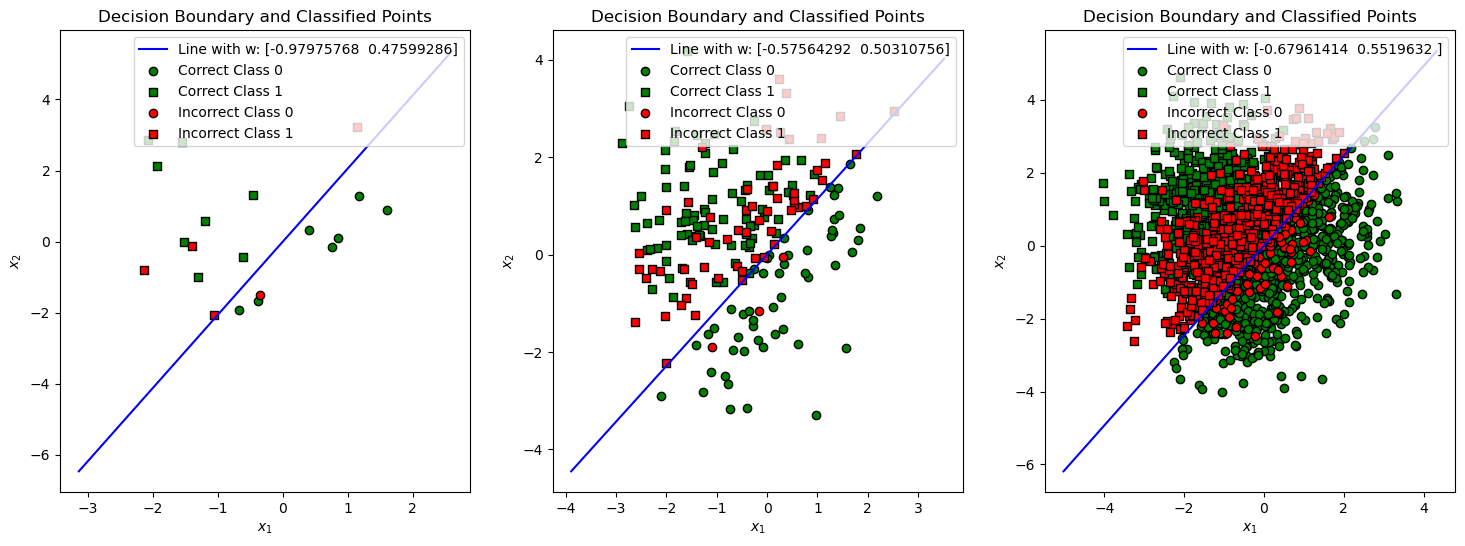

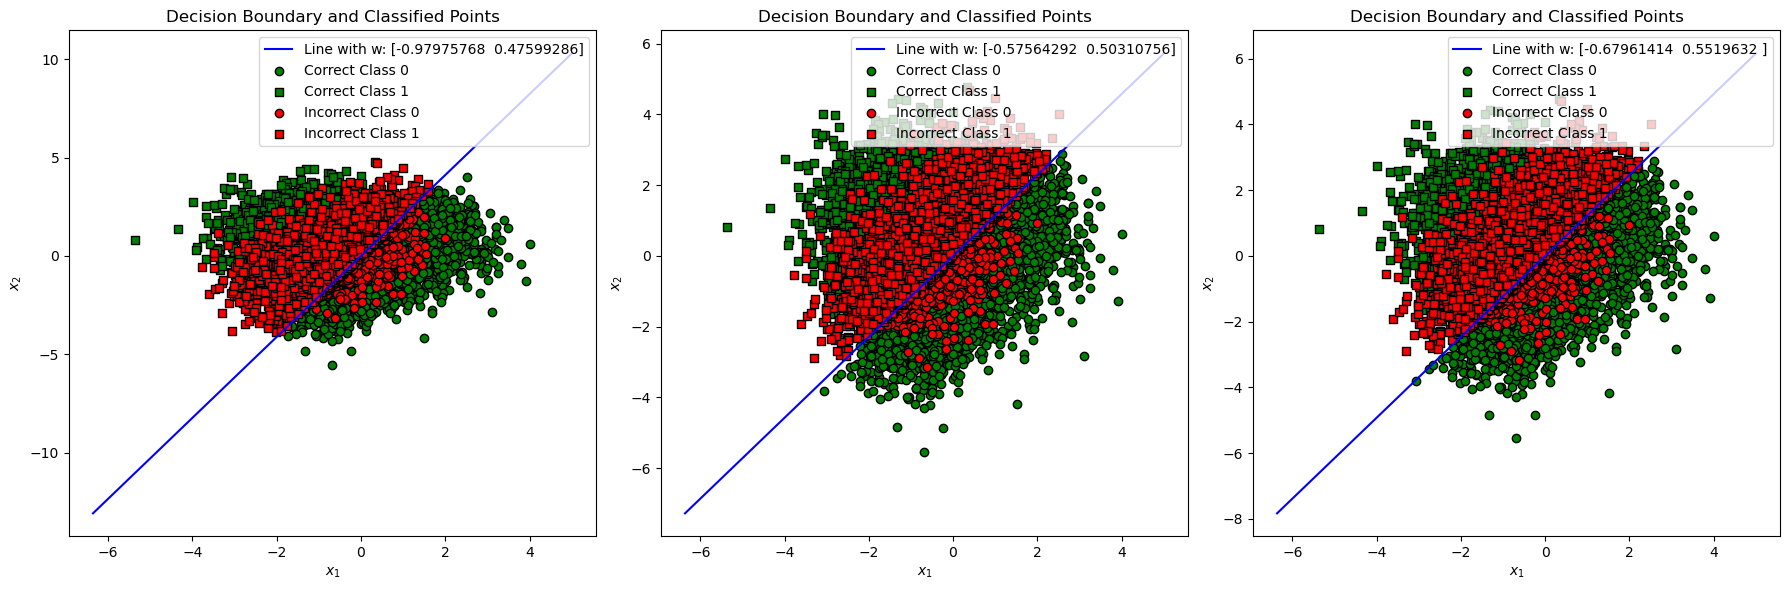

In [257]:
# Apply logistic regression for each dataset size and validate on D_10K with plots
fig_train, axes_train = plt.subplots(1, 3, figsize=(18, 6))  # 3 subplots for the 3 datasets
fig_val, axes_val = plt.subplots(1, 3, figsize=(18, 6))  # 3 subplots for the 3 datasets

for i, (X, y) in enumerate(zip(X_train, labels_train)):
    # Train logistic regression model on dataset
    w = train_logistic_regression(X, y)

    # Predict labels on training set
    y_pred_train = classify(X, w)

    # Predict labels on validation set
    y_pred_val = classify(X_val, w)
    
    prob_error_train = plot_decision_boundary_with_distinct_markers(X, y_pred_train, w, axes_train[i], y)
    prob_error_val = plot_decision_boundary_with_distinct_markers(X_val, y_pred_val, w, axes_val[i], labels_val)

    print(f'Probability of error on training dataset using the model trained with the training dataset D_{datasets_train_size[i]}: {prob_error_train:.4f}')
    print(f'Probability of error on validation dataset using the model trained with the training dataset D_{datasets_train_size[i]}: {prob_error_val:.4f}')
    # Plot decision boundary and classified points

# Show the plot
plt.tight_layout()
plt.show()

Probability of error on training dataset using the model trained with the training dataset D_20: 0.1434
Probability of error on validation dataset using the model trained with the training dataset D_20: 0.2665
Probability of error on training dataset using the model trained with the training dataset D_200: 0.2275
Probability of error on validation dataset using the model trained with the training dataset D_200: 0.2081
Probability of error on training dataset using the model trained with the training dataset D_2000: 0.2043
Probability of error on validation dataset using the model trained with the training dataset D_2000: 0.2053


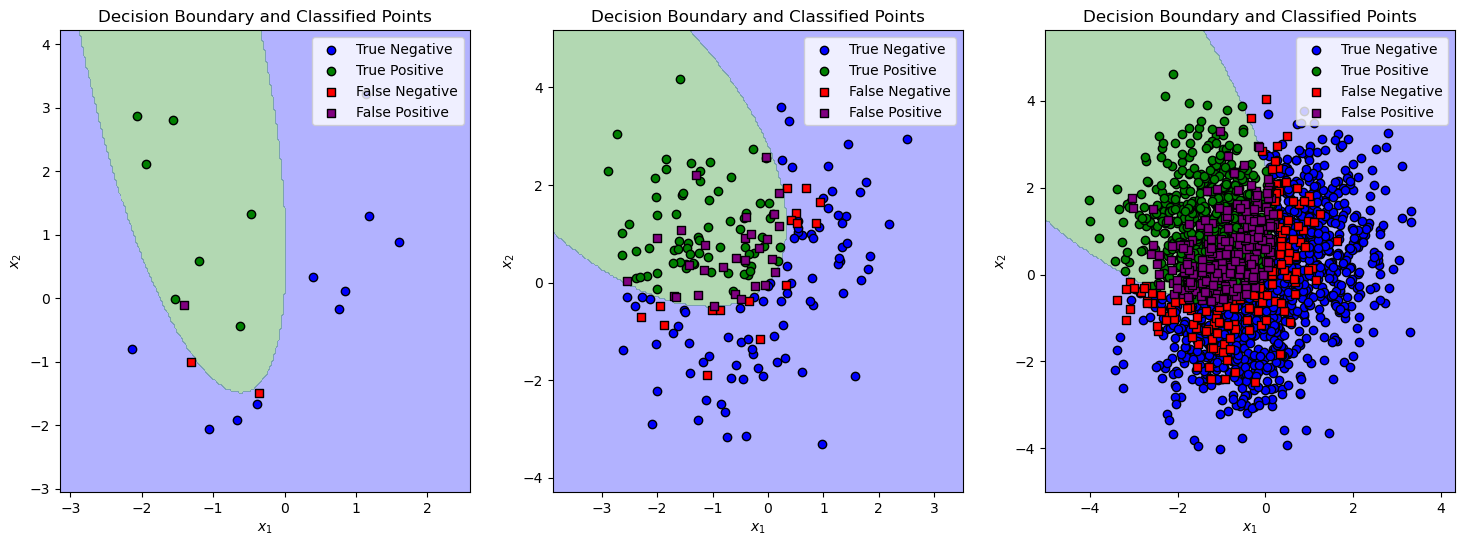

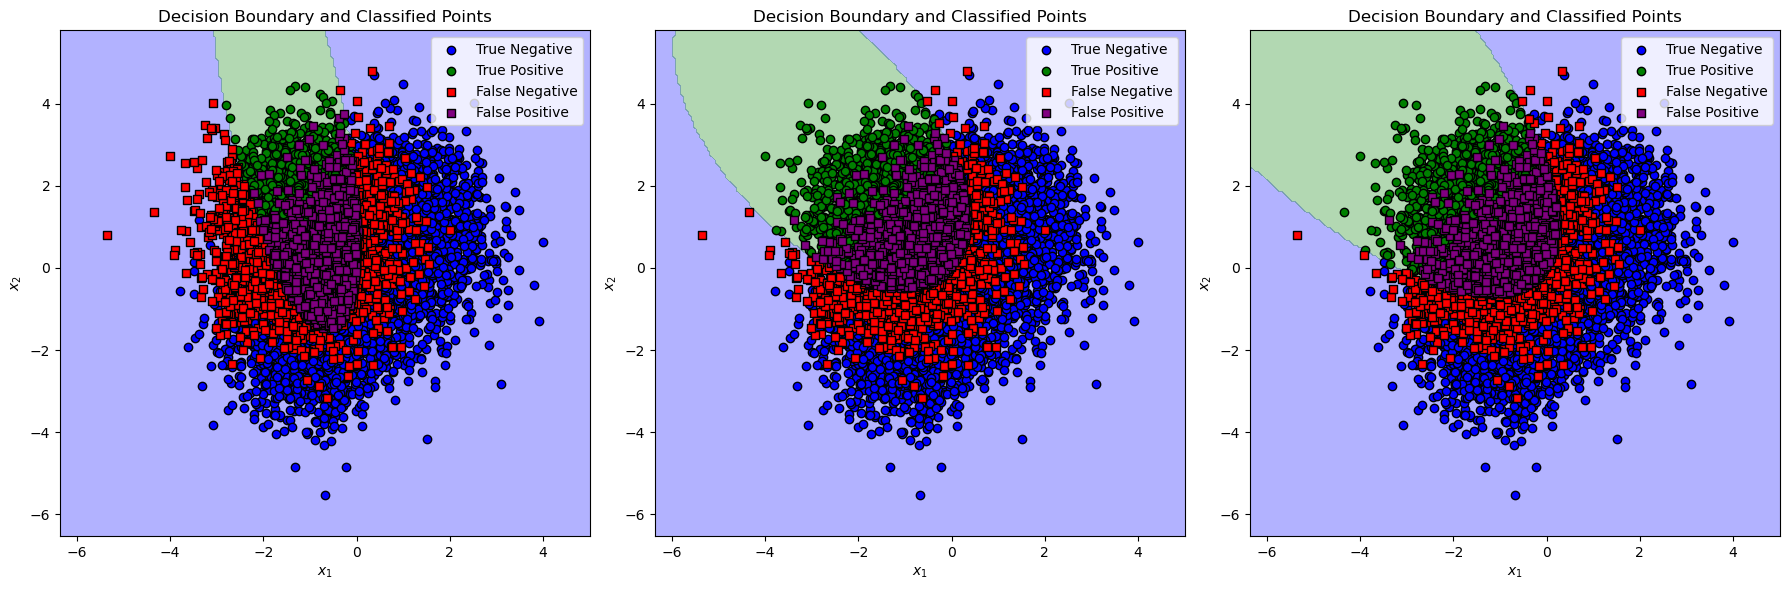

In [259]:
# Training quadratic logistic regression model using MLE
def train_quadratic_logistic_regression(X, y):
    # Add quadratic terms to X
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_quad = poly.fit_transform(X)

    w0 = np.zeros(X_quad.shape[1])  # Initialize weights as zeros
    result = minimize(nll_loss, w0, args=(X_quad, y), method='BFGS')  # Optimize the NLL
    return result.x, poly  # Return the optimized weights and the polynomial transformer

# Logistic regression classifier
def classify(X, w, poly):
    X_quad = poly.transform(X)  # Add quadratic terms
    probabilities = sigmoid(np.dot(X_quad, w))
    return (probabilities >= 0.5).astype(int)

def plot_decision_boundary_with_distinct_markers(X, y, w, ax, labels, poly):
    """
    Plots the decision boundary defined by the logistic regression model (w), 
    along with the correctly and incorrectly classified points from the validation set,
    using different markers for the two true classes.
    """
    # Meshgrid for plotting decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = classify(grid, w, poly).reshape(xx.shape)

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, levels=[-0.1, 0.5, 1.1], colors=["blue", "green"])

    # Correctly and incorrectly classified points
    TN = (y == 0) & (y == labels)
    TP = (y == 1) & (y == labels)
    FN = (y == 0) & (y != labels)
    FP = (y == 1) & (y != labels)

    FPR = np.sum(FP) / (np.sum(FP) + np.sum(TN))  # false positive probability
    FNR = np.sum(FN) / (np.sum(FN) + np.sum(TP))
    prob_error = FPR * priors[0] + FNR * priors[1]
    
    # True class 0 marker: 'o', True class 1 marker: 's'
    # Correctly classified points
    ax.scatter(X[TN, 0], X[TN, 1], marker='o', color='blue', label='True Negative', edgecolor='k')
    ax.scatter(X[TP, 0], X[TP, 1], marker='o', color='green', label='True Positive', edgecolor='k')
    
    # Incorrectly classified points
    ax.scatter(X[FN, 0], X[FN, 1], marker='s', color='red', label='False Negative', edgecolor='k')
    ax.scatter(X[FP, 0], X[FP, 1], marker='s', color='purple', label='False Positive', edgecolor='k')
    
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.legend(loc='upper right')
    ax.set_title("Decision Boundary and Classified Points")

    return prob_error

# Apply quadratic logistic regression for each dataset size and validate on D_10K with plots
fig_train, axes_train = plt.subplots(1, 3, figsize=(18, 6))  # 3 subplots for the 3 datasets
fig_val, axes_val = plt.subplots(1, 3, figsize=(18, 6))  # 3 subplots for the 3 datasets

for i, (X, y) in enumerate(zip(X_train, labels_train)):
    # Train quadratic logistic regression model on dataset
    w, poly = train_quadratic_logistic_regression(X, y)

    # Predict labels on training set
    y_pred_train = classify(X, w, poly)

    # Predict labels on validation set
    y_pred_val = classify(X_val, w, poly)
    
    prob_error_train = plot_decision_boundary_with_distinct_markers(X, y_pred_train, w, axes_train[i], y, poly)
    prob_error_val = plot_decision_boundary_with_distinct_markers(X_val, y_pred_val, w, axes_val[i], labels_val, poly)

    print(f'Probability of error on training dataset using the model trained with the training dataset D_{datasets_train_size[i]}: {prob_error_train:.4f}')
    print(f'Probability of error on validation dataset using the model trained with the training dataset D_{datasets_train_size[i]}: {prob_error_val:.4f}')

# Show the plot
plt.tight_layout()
plt.show()